In [1]:
import sympy as sm
import sympy.physics.mechanics as me
from pydy.system import System
import numpy as np
import matplotlib.pyplot as plt
from pydy.codegen.ode_function_generators import generate_ode_function
from scipy.integrate import odeint
import scipy.io as sio
me.init_vprinting()

In [2]:
ISS = me.ReferenceFrame('N') # ISS RF
B = me.ReferenceFrame('B') # body RF

q1, q2, q3 = me.dynamicsymbols('q1:4') # attitude coordinates (Euler angles)

B.orient(ISS, 'Body', (q1, q2, q3), 'xyz') # body RF

t = me.dynamicsymbols._t

In [3]:
O = me.Point('O') # fixed point in the ISS
O.set_vel(ISS, 0)

x, y, z = me.dynamicsymbols('x, y, z') # translation coordinates (position of the mass-center of Astrobee relative to 'O')
l = sm.symbols('l') # length of Astrobee (side of cube)

C = O.locatenew('C', x * ISS.x + y * ISS.y + z * ISS.z) # Astrobee CM

In [4]:
ux = me.dynamicsymbols('u_x')
uy = me.dynamicsymbols('u_y')
uz = me.dynamicsymbols('u_z')
u1 = me.dynamicsymbols('u_1')
u2 = me.dynamicsymbols('u_2')
u3 = me.dynamicsymbols('u_3')

z1 = sm.Eq(ux, x.diff())
z2 = sm.Eq(uy, y.diff())
z3 = sm.Eq(uz, z.diff())
z4 = sm.Eq(u1, q1.diff())
z5 = sm.Eq(u2, q2.diff())
z6 = sm.Eq(u3, q3.diff())
u = sm.solve([z1, z2, z3, z4, z5, z6], x.diff(), y.diff(), z.diff(), q1.diff(), q2.diff(), q3.diff())
u

In [5]:
C.set_vel(ISS, C.pos_from(O).dt(ISS).subs(u))
V_B_ISS_ISS = C.vel(ISS)
V_B_ISS_ISS # "velocity of Astrobee CM w.r.t ISS RF expressed in ISS RF"

In [6]:
A_B_ISS_ISS = C.acc(ISS).subs(u) #.subs(ud)
A_B_ISS_ISS # "acceleration of Astrobee CM w.r.t ISS RF expressed in ISS RF"

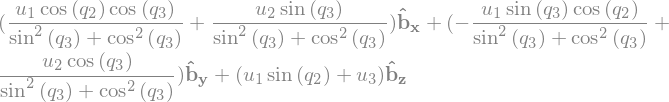

In [7]:
B.set_ang_vel(ISS, B.ang_vel_in(ISS).subs(u))
Omega_B_ISS_B = B.ang_vel_in(ISS)
Omega_B_ISS_B # "angular velocity of body RF w.r.t ISS RF expressed in body RF"

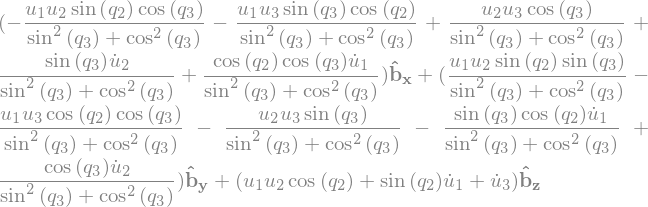

In [8]:
Alpha_B_ISS_B = B.ang_acc_in(ISS).subs(u) #.subs(ud)
Alpha_B_ISS_B # "angular acceleration of body RF w.r.t ISS RF expressed in body RF"

In [9]:
m = sm.symbols('m') # Astrobee mass

Ix, Iy, Iz = sm.symbols('I_x, I_y, I_z') # principal moments of inertia

I = me.inertia(B, Ix, Iy, Iz) # inertia dyadic
I

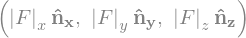

In [10]:
Fx_mag, Fy_mag, Fz_mag = me.dynamicsymbols('Fmag_x, Fmag_y, Fmag_z')

Fx = Fx_mag * ISS.x
Fy = Fy_mag * ISS.y
Fz = Fz_mag * ISS.z

Fx, Fy, Fz

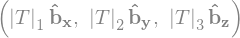

In [11]:
T1_mag, T2_mag, T3_mag = me.dynamicsymbols('Tmag_1, Tmag_2, Tmag_3')

T1 = T1_mag * B.x
T2 = T2_mag * B.y
T3 = T3_mag * B.z

T1, T2, T3

In [12]:
kdes = [z1.rhs - z1.lhs,
        z2.rhs - z2.lhs,
        z3.rhs - z3.lhs,
        z4.rhs - z4.lhs,
        z5.rhs - z5.lhs,
        z6.rhs - z6.lhs]

body = me.RigidBody('body', C, B, m, (I, C))
bodies = [body]

loads = [
         (C, Fx),
         (C, Fy),
         (C, Fz),
         (B, T1),
         (B, T2),
         (B, T3)
        ]

kane = me.KanesMethod(ISS, (x, y, z, q1, q2, q3), (ux, uy, uz, u1, u2, u3), kd_eqs=kdes)

fr, frstar = kane.kanes_equations(bodies, loads=loads)

In [13]:
sys = System(kane)

sys.constants_symbols

sys.constants = {
                 Ix: 0.1083,
                 Iy: 0.1083,
                 Iz: 0.1083,
                 m: 7
                }

sys.constants

In [14]:
sys.times = np.linspace(0.0, 50.0, num=1000)

sys.coordinates

In [15]:
sys.speeds

In [16]:
sys.states

In [17]:
sys.initial_conditions = {
                          x: 0.0,
                          y: 0.0,
                          z: 0.0,
                          q1: 0.0,
                          q2: 0.0,
                          q3: 0.0,
                          ux: 0.2,
                          uy: 0.0,
                          uz: 0.0,
                          u1: 0.0,
                          u2: 0.0,
                          u3: 0.5
                         }

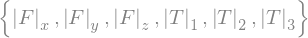

In [18]:
sys.specifieds_symbols

In [19]:
sys.specifieds = {
                  Fx_mag: 0.0,
                  Fy_mag: 0.0,
                  Fz_mag: 0.0,
                  T1_mag: 0.0,
                  T2_mag: 0.0,
                  T3_mag: 0.0
                 }

In [20]:
states = sys.integrate()

In [21]:
import matplotlib.pyplot as plt

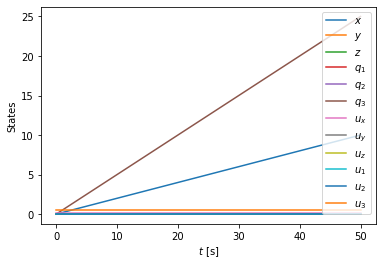

In [22]:
fig, ax = plt.subplots()
ax.plot(sys.times, states)
ax.set_xlabel('{} [s]'.format(sm.latex(t, mode='inline')));
ax.set_ylabel('States');
ax.legend(['$x$', '$y$', '$z$', '$q_1$', '$q_2$', '$q_3$', '$u_x$', '$u_y$', '$u_z$', '$u_1$', '$u_2$', '$u_3$'], fontsize=10)
plt.show()

In [23]:
from pydy.viz import Box, Cube, Sphere, Cylinder, VisualizationFrame, Scene

In [24]:
l = 0.32

body_m_shape = Box(l, (1/2) * l, (2/3) * l, color='black', name='body_m_shape')
body_l_shape = Box(l, (1/4) * l, l, color='green', name='body_l_shape')
body_r_shape = Box(l, (1/4) * l, l, color='green', name='body_r_shape')

v1 = VisualizationFrame('Body_m',
                        B,
                        C.locatenew('C_m', (1/6) * l * B.z),
                        body_m_shape)

v2 = VisualizationFrame('Body_l',
                        B,
                        C.locatenew('C_l', (3/8) * l * -B.y),
                        body_l_shape)

v3 = VisualizationFrame('Body_r',
                        B,
                        C.locatenew('C_r', (3/8) * l * B.y),
                        body_r_shape)

scene = Scene(ISS, O, system=sys)

scene.visualization_frames = [v1, v2, v3]

In [25]:
scene.display_jupyter(axes_arrow_length=1.0)

/home/docs/checkouts/readthedocs.org/user_builds/pydy/conda/v0.6.0/lib/python3.8/site-packages/jupyter_client/session.py:716: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


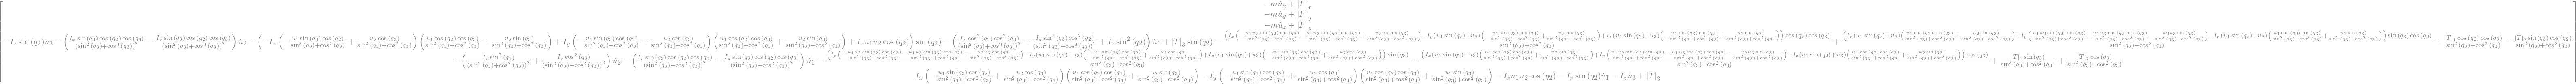

In [26]:
f = fr + frstar
f

In [27]:
V = {
      x: 0.0,
      y: 0.0,
      z: 0.0,
      q1: 0.0,
      q2: 0.0,
      q3: 0.0,
      ux: 0.0,
      uy: 0.0,
      uz: 0.0,
      u1: 0.0,
      u2: 0.0,
      u3: 0.0,
      Fx_mag: 0.0,
      Fy_mag: 0.0,
      Fz_mag: 0.0,
      T1_mag: 0.0,
      T2_mag: 0.0,
      T3_mag: 0.0
}

V_keys = sm.Matrix([ v for v in V.keys() ])
V_values = sm.Matrix([ v for v in V.values() ])

In [28]:
us = sm.Matrix([ux, uy, uz, u1, u2, u3])
us_diff = sm.Matrix([ux.diff(), uy.diff(), uz.diff(), u1.diff(), u2.diff(), u3.diff()])
qs = sm.Matrix([x, y, z, q1, q2, q3])
rs = sm.Matrix([Fx_mag, Fy_mag, Fz_mag, T1_mag, T2_mag, T3_mag])

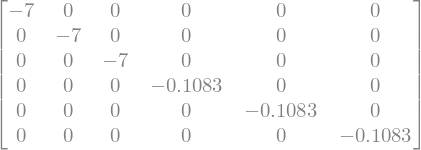

In [29]:
Ml = f.jacobian(us_diff).subs(sys.constants).subs(V)
Ml

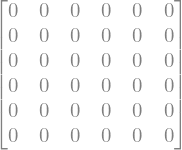

In [30]:
Cl = f.jacobian(us).subs(V)
Cl.subs(sys.constants)

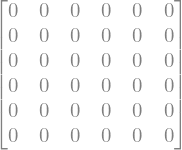

In [31]:
Kl = f.jacobian(qs).subs(V)
sm.simplify(Kl.subs(sys.constants))

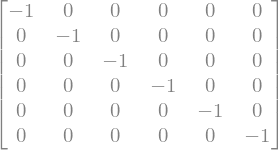

In [32]:
Hl = -f.jacobian(rs).subs(V)
sm.simplify(Hl.subs(sys.constants))

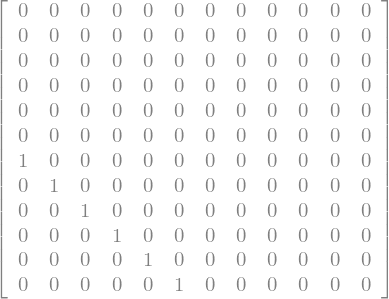

In [33]:
A = sm.Matrix([[(-Ml.inv()*Cl), (-Ml.inv()*Kl)], [(sm.eye(6)), sm.zeros(6, 6)]])
sm.simplify(A.subs(sys.constants))

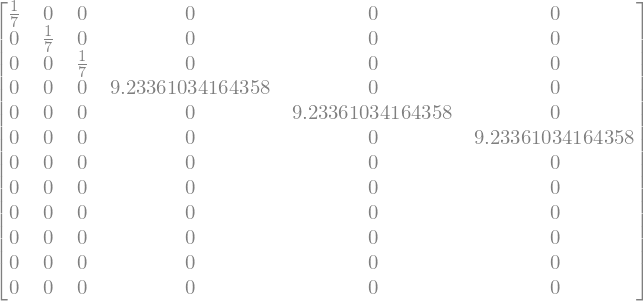

In [34]:
B = sm.Matrix([[Ml.inv() * Hl], [sm.zeros(6, 6)]])
sm.nsimplify(B.subs(sys.constants))